<a href="https://colab.research.google.com/github/Wazhee/Semantic-Segmentation/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms as T
from torchvision import models

torch.manual_seed(0)
np.random.seed(0)

In [2]:
!gdown https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&export=download
!unzip -qq cityscapes.zip

Downloading...
From: https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4
To: /content/cityscapes.zip
100% 651M/651M [00:03<00:00, 180MB/s]


In [3]:
class Segmenter(torch.nn.Module):
    def __init__(self, n_classes, encoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64, n_classes, kernel_size=(3,3), padding=1),
        )

    def forward(self, x):
      out1 = self.encoder(x)
      out2 = self.decoder(out1)
      return out2 # Your code for Problem 1a goes here

In [4]:
class CityScapesDataset(Dataset):
  def __init__(self, images, labels, im_transform, mask_transform):
    self.images = images
    self.labels = labels
    self.im_transform = im_transform
    self.mask_transform = mask_transform
  
  def __getitem__(self, idx):
    im = Image.open(self.images[idx])
    mask = Image.open(self.labels[idx])
    im = self.im_transform(im)[0:3, ...] # Transform image

    # Add an extra first dimension to mask (needed for transforms), convert
    # to LongTensor b/c values are integers, and apply transforms.
    mask = np.asarray(mask)[None, ...] 
    mask = torch.LongTensor(mask)
    mask = self.mask_transform(mask)

    # Apply random horizontal flip to image and mask
    if np.random.rand() > 0.5:
      im = TF.hflip(im)
      mask  = TF.hflip(mask)

    return im, mask

  def __len__(self):
    return len(self.images)

In [5]:
batch_size = 16

# Make image and mask transforms.
im_transform = [T.ToTensor()]
im_transform.append(T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR))
im_transform = T.Compose(im_transform)

mask_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)

def get_dataloader(im_path):
  images = sorted(glob.glob(im_path + '/*8bit.jpg'))
  labels = sorted(glob.glob(im_path + '/*labelIds.png'))   
  dataset = CityScapesDataset(images, labels, im_transform, mask_transform)
  return data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Create dataloaders
train_dataloader = get_dataloader('./cityscapes/train')
val_dataloader = get_dataloader('./cityscapes/val')

In [6]:
# Get features from VGG16 up through 3 downsampling (maxpool) operations.
vgg = models.vgg16(pretrained=True);
encoder = nn.Sequential(*(list(vgg.children())[:1])[0][0:17]);

# Create model
n_classes = 34
model = Segmenter(n_classes, encoder);
model.to('cuda');

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 278MB/s]


## Train/Test Loop

In [39]:
def train_loop(train_dataloader, model, loss_fn, optimizer, old_loss, epochs, device):
  size = len(train_dataloader.dataset)
  for batch, (X, y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    # Compute prediction and loss
    #print(f"y.shape: {y[:,0,:,:].shape}")
    pred = model(X)
    #print(f"pred: {type(X)}, y: {type(y)}")
    loss = loss_fn(pred, y[:,0,:,:])
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      # if loss < old_loss:
      #   save_model(model, loss, epochs, optimizer)
      #   old_loss = loss
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in dataloader:
        X,y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y[:,0,:,:]).item()
        correct += (pred.argmax(1) == y[:,0,:,:]).type(torch.float).sum().item()
        
  test_loss /= num_batches
  correct /= (size * y[:,0,:,:].shape[0]* y[:,0,:,:].shape[1] *y[:,0,:,:].shape[2])
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
batch, (X,y) = next(enumerate(train_dataloader))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [35]:
y[:,0,:,:].flatten().shape

torch.Size([1048576])

In [10]:
device='cuda'
X,y = X.to(device), y.to(device)
pred = model(X)

In [30]:
(pred.argmax(1) == y[:,0,:,:]).type(torch.float).sum().item()

1701.0

In [37]:
1701.0 / (16*256*256)

0.0016222000122070312

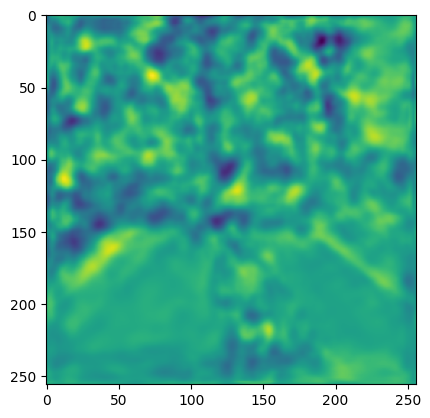

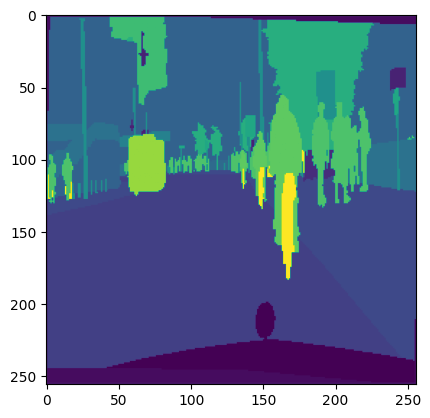

In [26]:
plt.imshow(pred[1,1,:,:].cpu().detach().numpy())
plt.figure()
plt.imshow(y[0,0,:,:].cpu().detach().numpy())

In [13]:
loss_fn = nn.CrossEntropyLoss()
test_loop(val_dataloader, model, loss_fn, 'cuda')

Test Error: 
 Accuracy: 10277.1%, Avg loss: 0.630697 



In [40]:
import warnings
from tqdm import tqdm
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

device = 'cuda'
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 7
old_loss = 10
# Problem 1b: Your training loop code goes here
for t in tqdm(range(num_epochs)):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer, old_loss, num_epochs, device)
  test_loop(val_dataloader, model, loss_fn, device)
  #loss_arr.append(get_loss(train_dataloader, model, loss_fn))
print("Done!")


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 2.590940  [   16/ 2975]
loss: 0.931287  [ 1616/ 2975]


 14%|█▍        | 1/7 [04:07<24:43, 247.26s/it]

Test Error: 
 Accuracy: 19.4%, Avg loss: 0.806736 

Epoch 2
-------------------------------
loss: 0.705466  [   16/ 2975]
loss: 0.530562  [ 1616/ 2975]


 29%|██▊       | 2/7 [08:24<21:06, 253.26s/it]

Test Error: 
 Accuracy: 20.0%, Avg loss: 0.719893 

Epoch 3
-------------------------------
loss: 0.708206  [   16/ 2975]
loss: 0.609583  [ 1616/ 2975]


 43%|████▎     | 3/7 [12:34<16:46, 251.72s/it]

Test Error: 
 Accuracy: 20.3%, Avg loss: 0.667085 

Epoch 4
-------------------------------
loss: 0.626404  [   16/ 2975]
loss: 0.596130  [ 1616/ 2975]


 57%|█████▋    | 4/7 [16:46<12:34, 251.59s/it]

Test Error: 
 Accuracy: 20.5%, Avg loss: 0.631955 

Epoch 5
-------------------------------
loss: 0.557041  [   16/ 2975]
loss: 0.558566  [ 1616/ 2975]


 71%|███████▏  | 5/7 [20:55<08:21, 250.78s/it]

Test Error: 
 Accuracy: 20.5%, Avg loss: 0.622291 

Epoch 6
-------------------------------
loss: 0.698734  [   16/ 2975]
loss: 0.554597  [ 1616/ 2975]


 86%|████████▌ | 6/7 [25:07<04:11, 251.23s/it]

Test Error: 
 Accuracy: 20.7%, Avg loss: 0.600341 

Epoch 7
-------------------------------
loss: 0.489146  [   16/ 2975]
loss: 0.542754  [ 1616/ 2975]


100%|██████████| 7/7 [29:15<00:00, 250.80s/it]

Test Error: 
 Accuracy: 20.7%, Avg loss: 0.594438 

Done!


In [42]:
from google.colab import drive
drive.mount('/content/drive')

# save model
"""Save model checkpoint"""
# Additional information
EPOCH = num_epochs
PATH = "/content/drive/MyDrive/Comp 546: Computer Vision/best_seg_model.pt"
#LOSS = loss
torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

Mounted at /content/drive


In [ ]:
# Problem 1c: Your IoU evaluation code goes here

In [ ]:
# Problem 1d: Your image results code goes here